In [1]:
import sys
import os
import pandas as pd
import numpy as np
import scipy
import gget
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
from importlib import reload
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
import networkx as nx
import xgi

source_path = os.path.abspath("../source/")
sys.path.append(source_path)
import utils as ut
import plotting as plt2
import hypercore as hc
import matrix as matrix
import centrality as central

In [2]:
# load the population data
fpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/population_pore_c/chr1_1000000_incidence.parquet"

df = pd.read_parquet(fpath)
print(f"{df.shape=}")
df.head()

df.shape=(193, 122676)


read_code,65057,21695,119867,7453,65998,81009,110088,18720,89300,115287,...,47296,6202,3069,97901,6136,88389,111230,69764,94327,2373
bin,,,,,,,,,,,,,,,,,,,,,
4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Summary Statistics

In [3]:
degrees = df.sum(axis=1)
orders = df.sum(axis=0)

print(f"{degrees.mean()=:.2f}")
print(f"{orders.mean()=:.2f}")

# get the degree of higher order contacts
high_order_idx = np.argwhere(orders.values > 2).ravel()

print("Number of higher-order contacts")
df.columns[high_order_idx].shape

degrees.mean()=1610.08
orders.mean()=2.53
Number of higher-order contacts


(40694,)

# Plot some contacts

Text(0.5, 1.0, 'Sample of 500 Hyperedges from Population Pore-C')

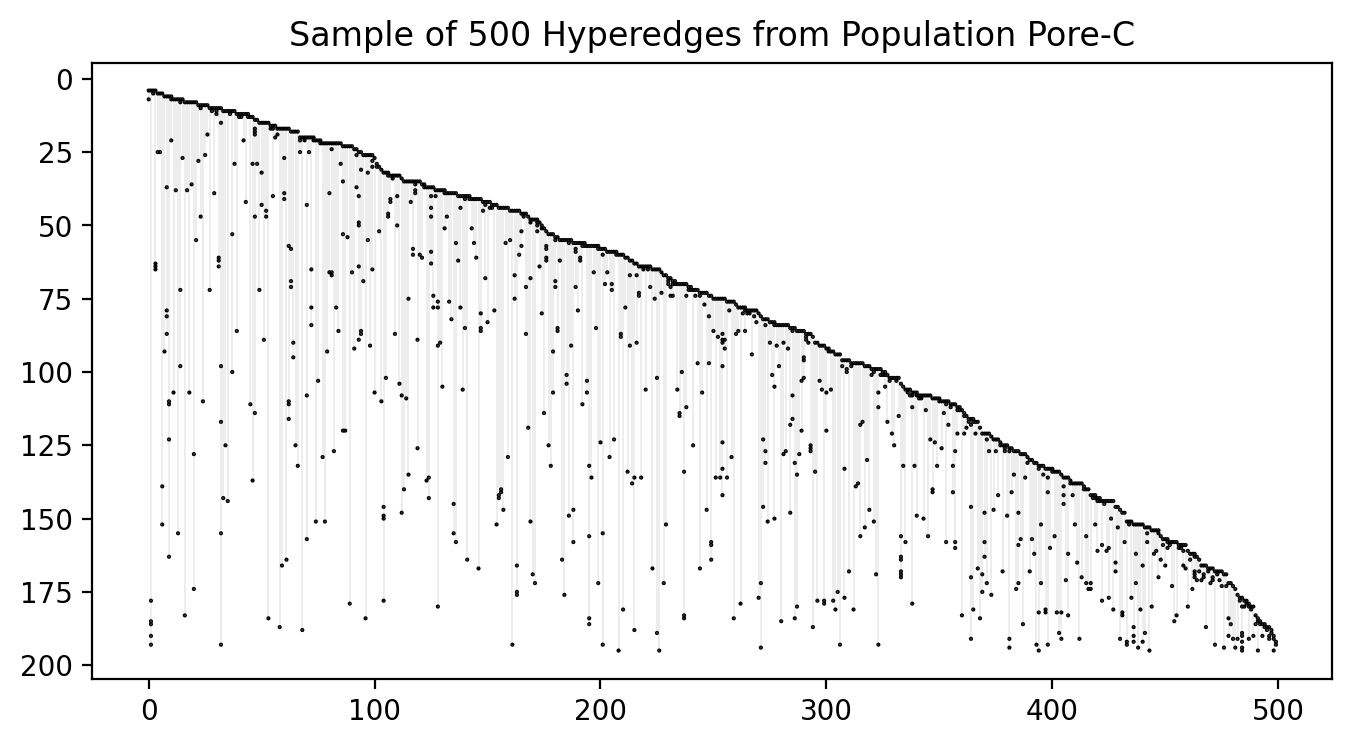

In [4]:
node_params = {
    's' : 1,
    'ec' : 'k',
    'lw' : 1,
    'marker' : ".",
    'zorder' : 2,
}

line_params = {
    'lw' : 0.1,
    'alpha' : 0.5,
    'zorder' : 1,
}

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 4

sample_size = 500
plt2.plot_incidence(ut.sort_by_lowest_index(df.T.sample(sample_size).T), 
               node_color='k',
               node_params=node_params,
               line_params=line_params)

plt.title(f"Sample of {sample_size} Hyperedges from Population Pore-C")

# k-m hypercore

In [5]:
m = 3
k = 40

# prepare data
data = ut.incidence_to_list_of_list(df)
data = hc.prepare_for_hypercore_decomp(data, k=2)

# perform decomposition
mk_hyper = hc.m_k_decomposition(data, m, k)
print(mk_hyper)

I = hc.xgi_to_incidence(mk_hyper)
A = matrix.clique_expand_incidence(I, zero_diag=False)  

print(f"{I.shape=} {A.shape=}")
I.head()

Unnamed Hypergraph with 193 nodes and 36132 hyperedges
I.shape=(193, 36132) A.shape=(193, 193)


,0,1,2,3,4,5,6,7,8,9,...,36122,36123,36124,36125,36126,36127,36128,36129,36130,36131
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
degrees_core = I.sum(axis=1).reset_index()
degrees_core['bin'] = df.index 
degrees_core = degrees_core.drop(columns=['index'])
degrees_core.columns = ['degree_core', 'bin']

degrees_core.head()

,degree_core,bin
0,402,4.0
1,517,5.0
2,466,6.0
3,557,7.0
4,467,8.0


# Integrate Gene-Level Information

In [7]:
# get SCENIC Mouse TFS
fpath = "/nfs/turbo/umms-indikar/shared/projects/DGC/data/processed_data/MOUSE_500bp_up_100bp_down_B.csv"
scenic = pd.read_csv(fpath)
scenic = scenic.rename(columns={'Unnamed: 0': 'gene_name'})
scenic = scenic.set_index('gene_name')
mouse_tfs = scenic.columns.to_list()

print(f"{len(mouse_tfs)=}")

scenic.head()

len(mouse_tfs)=1605


,ABL1,ACAA1,ADNP,ADNP2,AEBP2,AFF4,AHCTF1,AHDC1,AHR,AHRR,...,ZSCAN32,ZSCAN4,ZSCAN5A,ZSCAN5B,ZSCAN5C,ZSCAN9,ZXDA,ZXDB,ZXDC,ZZZ3
gene_name,,,,,,,,,,,,,,,,,,,,,
0610005C13Rik,0.00,0.0,4.300,0.000,0.0,5.25,4.37,0.018250,1.2576,0.0,...,0.0,0.0,0.0,0.0,0.538,0.0,0.0,0.0,0.0,0.0326
0610007P14Rik,6.56,0.0,0.685,0.841,0.0,2.55,1.54,0.449875,1.0866,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.4870
0610009B22Rik,1.18,0.0,0.721,0.000,0.0,1.13,1.44,0.282500,1.4038,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,1.8900
0610009L18Rik,0.00,0.0,0.000,0.414,0.0,1.24,1.43,1.109500,2.3160,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0000
0610009O20Rik,2.10,0.0,0.147,0.000,0.0,5.12,1.75,0.471513,0.1480,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.2870


In [8]:
# load a the gene table
fpath = "/scratch/indikar_root/indikar1/shared_data/scpore_c/gtf/GRCm39.gene_table.parquet"

resolution = 1000000

gdf = pd.read_parquet(fpath)
gdf = gdf[gdf['Chromosome'] == "1"]
gdf['gene_name'] = gdf['gene_name'].str.upper()
gdf['midpoint'] = ((gdf['End'] - gdf['Start']) / 2) + gdf['Start']
gdf['is_tf'] = gdf['gene_name'].isin(mouse_tfs)
gdf['bin'] = gdf['midpoint'].apply(lambda x: ut.bin_loci(x, resolution))

print(f"TFS on chromosome 1:")
print(gdf['is_tf'].value_counts())                                   
                                   
gdf.head()

TFS on chromosome 1:
is_tf
False    1135
True       70
Name: count, dtype: int64


,gene_name,gene_id,Chromosome,Start,End,midpoint,is_tf,bin
0,PCMTD1,ENSMUSG00000051285,1,7159143,7243852,7201497.5,False,8.0
1,CDH7,ENSMUSG00000026312,1,109910160,110067887,109989023.5,False,110.0
2,EXO1,ENSMUSG00000039748,1,175708146,175741055,175724600.5,False,176.0
3,BECN2,ENSMUSG00000104158,1,175747894,175749791,175748842.5,False,176.0
4,ASIC4,ENSMUSG00000033007,1,75427079,75450987,75439033.0,False,76.0


# Load RNA Expression (Kauffman Paper)

In [9]:
fpath = "/nfs/turbo/umms-indikar/shared/projects/poreC/data/kauffmanRNA/4DNFICXJQ3PA.tsv"

usecols = [
    'gene_id',
    'transcript_id',  
    'length', 
    'TPM', 
    'FPKM', 
]
edf = pd.read_csv(fpath, sep='\t', usecols=usecols)
print(f"{edf.shape=}")
# edf = edf[edf['TPM'] > 0]
edf['gene_id'] = edf['gene_id'].apply(lambda x: x.split(".")[0])

# sum expression over all isoforms
edf = edf.groupby('gene_id')['TPM'].sum().reset_index()

print(f"{edf.shape=}")
edf.head()

edf.shape=(168207, 5)
edf.shape=(81881, 2)


,gene_id,TPM
0,10000,0.0
1,10001,0.0
2,10002,0.0
3,10003,0.0
4,10004,0.0


In [10]:
gdf = pd.merge(gdf, edf, how='left')
gdf['TPM'] = gdf['TPM'].fillna(0)
gdf['log_TPM'] = np.log1p(gdf['TPM'])
gdf.head()

,gene_name,gene_id,Chromosome,Start,End,midpoint,is_tf,bin,TPM,log_TPM
0,PCMTD1,ENSMUSG00000051285,1,7159143,7243852,7201497.5,False,8.0,18.45,2.967847
1,CDH7,ENSMUSG00000026312,1,109910160,110067887,109989023.5,False,110.0,0.00,0.000000
2,EXO1,ENSMUSG00000039748,1,175708146,175741055,175724600.5,False,176.0,43.10,3.786460
3,BECN2,ENSMUSG00000104158,1,175747894,175749791,175748842.5,False,176.0,0.00,0.000000
4,ASIC4,ENSMUSG00000033007,1,75427079,75450987,75439033.0,False,76.0,0.10,0.095310


# Summary of Features by Genomic Loci

Fri Jun  7 09:13:49 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Fri Jun  7 09:13:49 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Fri Jun  7 09:13:49 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Fri Jun  7 09:13:49 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Fri Jun  7 09:13:49 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates

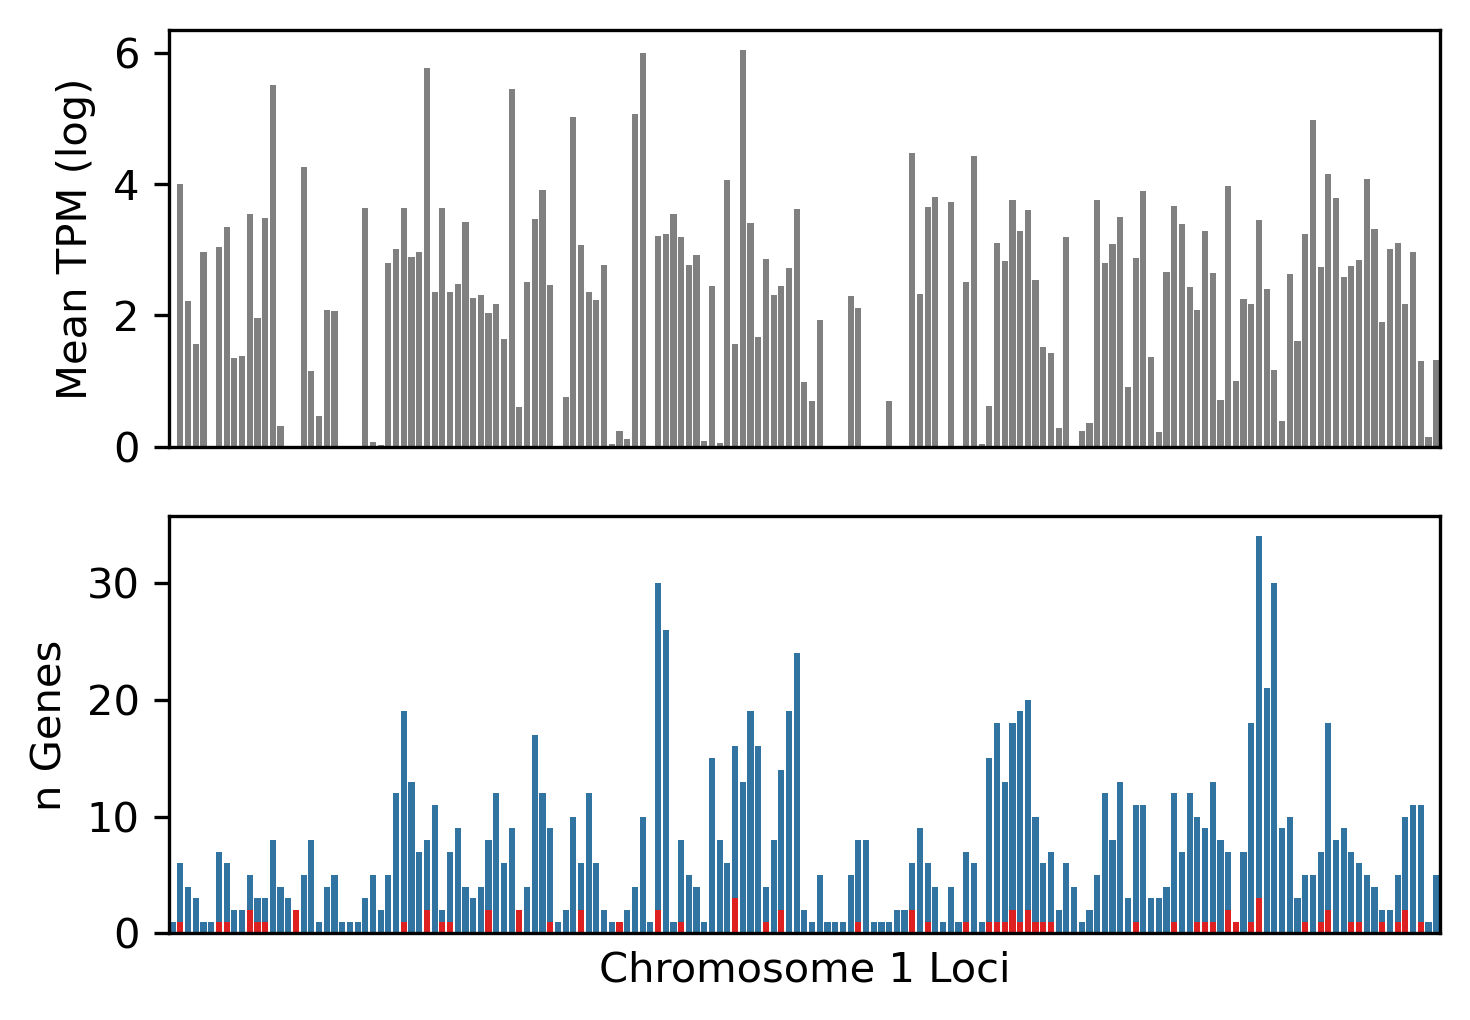

In [11]:
# plot bin level gene stats
gx = gdf.groupby('bin').agg(
    mean_tpm = ('TPM', 'mean'),
    n_genes = ('gene_name', 'count'),
    n_tfs = ('is_tf', 'sum'),
).reset_index()

gx['bin'] = gx['bin'].astype(int)
gx['log_TPM'] = np.log1p(gx['mean_tpm'])

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 3.5

fig, axs = plt.subplots(2, 1, sharex=True)

sns.barplot(data=gx, 
            x='bin', 
            y='log_TPM',
            color='grey',
            ax=axs[0])

sns.barplot(data=gx, 
            x='bin', 
            y='n_genes',
            ax=axs[1])

sns.barplot(data=gx, 
            x='bin', 
            y='n_tfs',
            color='r',
            ax=axs[1]
           )

axs[0].set_ylabel('Mean TPM (log)')
axs[1].set_ylabel('n Genes')
plt.xticks([])
plt.xlabel("Chromosome 1 Loci")

plt.tight_layout()

# Most Highly Expressed

In [12]:
gdf = gdf.sort_values(by='TPM', ascending=False)

database = 'celltypes'
result = gget.enrichr(gdf['gene_name'].head(100).to_list(), database=database)

result.head(5)

Fri Jun  7 09:13:50 2024 INFO Performing Enichr analysis using database PanglaoDB_Augmented_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


,rank,path_name,p_val,z_score,combined_score,overlapping_genes,adj_p_val,database
0,1,Pluripotent Stem Cells,0.000248,9.735858,80.817003,"[PARP1, NCL, MCM3, HNRNPU, TERF1]",0.014897,PanglaoDB_Augmented_2021
1,2,Ionocytes,0.016548,5.886994,24.145517,"[ELF3, TFCP2L1, ATP1B1]",0.382150,PanglaoDB_Augmented_2021
2,3,Cardiac Stem And Precursor Cells,0.019107,5.564199,22.021293,"[ENAH, FN1, LAMC1]",0.382150,PanglaoDB_Augmented_2021
3,4,Distal Tubule Cells,0.031419,4.562086,15.786317,"[ELF3, TFCP2L1, ATP1B1]",0.471292,PanglaoDB_Augmented_2021
4,5,Reticulocytes,0.094020,4.000606,9.458428,"[DHX9, MCM3]",0.594426,PanglaoDB_Augmented_2021


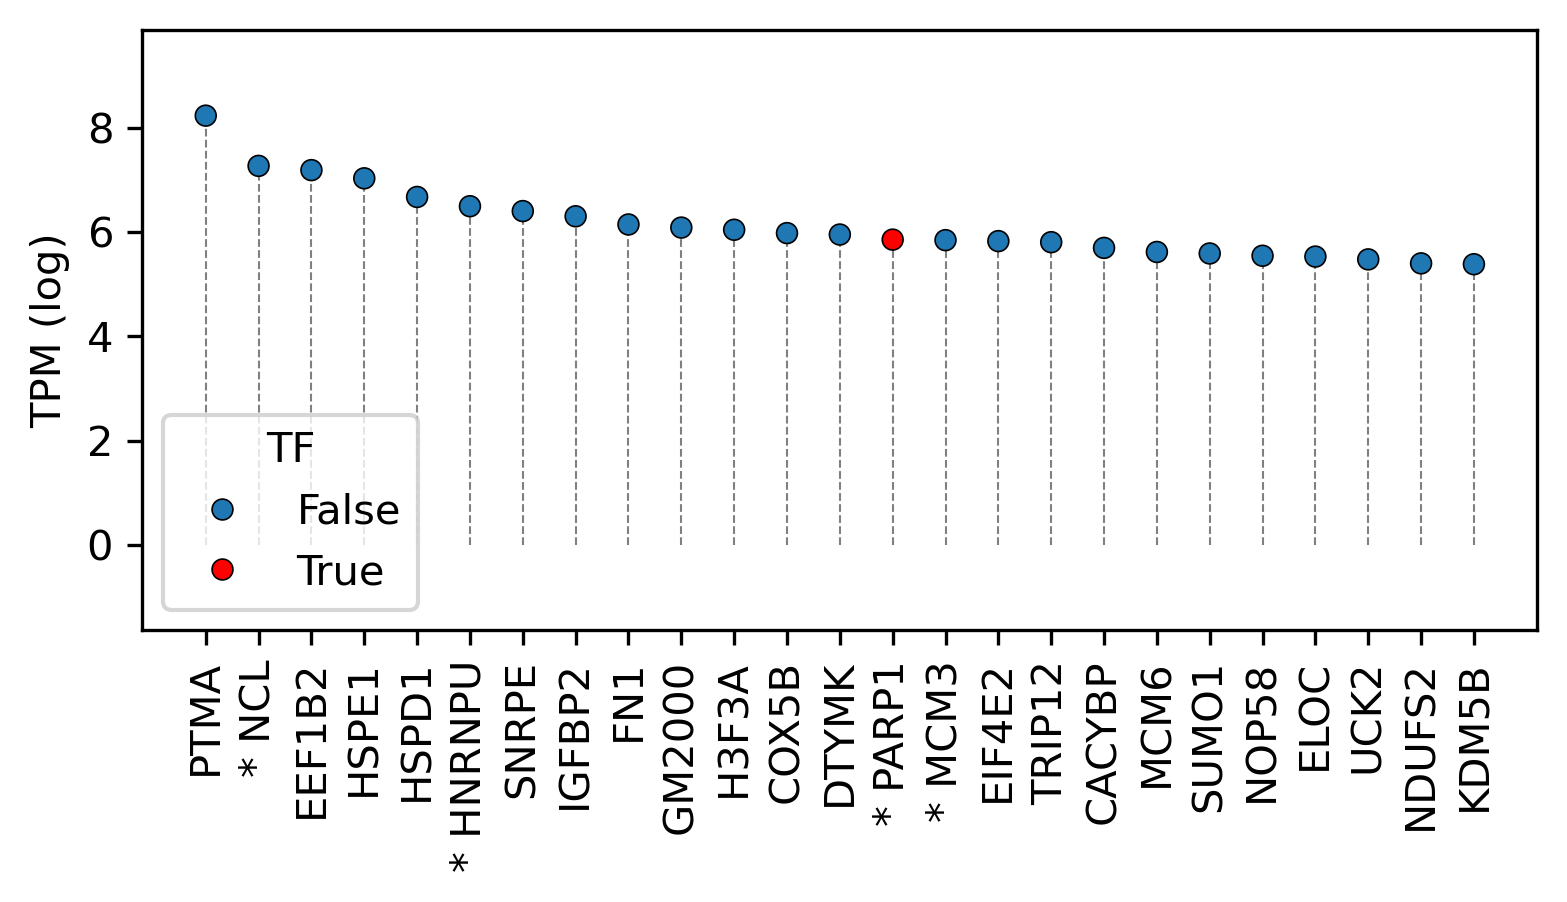

In [13]:
n_genes = 25

esc_genes = [
    'PARP1',
    'NCL',
    'MCM3', 
    'HNRNPU',
    'TERF1',
]

pdf = gdf.copy()
pdf = pdf[~pdf['gene_name'].str.startswith("RP")]
pdf['gene_name'] = np.where(pdf['gene_name'].isin(esc_genes), "* " + pdf['gene_name'], pdf['gene_name'])

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 2.6

ax = sns.scatterplot(data=pdf.head(n_genes),
            y='log_TPM',
            x='gene_name',
            hue='is_tf',
            ec='k',
            s=25,
            palette=['C0', 'r'], )

# for point in ax.collections[0].get_offsets():  
#     ax.hlines(point[1], 
#               0,
#               point[0], 
#               colors='grey',
#               ls='--',
#               lw=0.5,
#               zorder=0)  
    
for point in ax.collections[0].get_offsets():
    ax.vlines(point[0],  # Use the x-coordinate for the vertical line
              0,         
              point[1],  # Use the y-coordinate as the upper limit
              colors='grey', 
              ls='--', 
              lw=0.5, 
              zorder=0) 

plt.xlabel("")
plt.ylabel("TPM (log)")

plt.gca().tick_params(axis='x', rotation=90)

sns.move_legend(ax,  
                loc='lower left',
                title='TF')

plt.margins(y=0.2, x=0.05)

# Gene Summaries

In [14]:
def summarize_gene_data(gdf):
    pdf = gdf.copy()
    nz_mask = pdf['TPM'] > 0
    # Printing overall gene and TF counts with clear formatting
    print("\n--- Overall Counts ---\n")
    print(f"- Total Number of Genes: {pdf['gene_name'].nunique()}")
    print(f"- Number of Genes with TPM > 0: {pdf[nz_mask]['gene_name'].nunique()}")
    print(f"- Total Number of TFs: {pdf['is_tf'].sum()}")
    print(f"- Number of TFs with TPM > 0: {pdf[nz_mask]['is_tf'].sum()}")
    
summarize_gene_data(gdf)


--- Overall Counts ---

- Total Number of Genes: 1202
- Number of Genes with TPM > 0: 896
- Total Number of TFs: 70
- Number of TFs with TPM > 0: 58


In [15]:
print(pdf.groupby('bin')[['TPM']].describe())

        TPM                                                           
      count       mean        std    min    25%    50%     75%     max
bin                                                                   
4.0     1.0   0.020000        NaN   0.02   0.02   0.02   0.020    0.02
5.0     5.0  63.896000  68.133474   0.30   1.91  58.69  96.870  161.71
6.0     4.0   8.250000  16.167098   0.00   0.18   0.25   8.320   32.50
7.0     3.0   3.813333   6.604887   0.00   0.00   0.00   5.720   11.44
8.0     1.0  18.450000        NaN  18.45  18.45  18.45  18.450   18.45
...     ...        ...        ...    ...    ...    ...     ...     ...
191.0   9.0   6.862222   7.822512   0.00   0.94   5.56   9.490   19.70
192.0  11.0  18.421818  18.895474   0.05   3.73  11.35  32.905   58.08
193.0  11.0   2.680000   4.840589   0.00   0.25   1.17   2.495   16.76
194.0   1.0   0.170000        NaN   0.17   0.17   0.17   0.170    0.17
195.0   5.0   2.774000   4.991290   0.00   0.00   0.84   1.390   11.64

[165 

# Expressed TFs

In [16]:
# get the expressed TFs
pdf = gdf.copy()

pdf = gdf.copy()
pdf = pdf[~pdf['gene_name'].str.startswith("RP")]
pdf = pdf[pdf['is_tf']]

print(pdf['gene_name'].unique())



pdf.head(10)

['PARP1' 'TFCP2L1' 'USF1' 'ELF3' 'TERF1' 'RBBP5' 'AHCTF1' 'VPS4B' 'CCNT2'
 'GBX2' 'PRDM14' 'GLI2' 'NR5A2' 'SOX13' 'POU2F1' 'CREB1' 'NCOA2' 'HES6'
 'TAF1A' 'STAT1' 'ELK4' 'ATF3' 'ZBTB18' 'MSC' 'ZBED6' 'ATF6' 'MYBL1'
 'ARID5A' 'ZBTB41' 'STAT4' 'KLF7' 'ZBTB37' 'SOX17' 'NPAS2' 'PBX1' 'YOD1'
 'SATB2' 'CARF' 'IRF6' 'BATF3' 'TCF24' 'MIXL1' 'POU3F3' 'IKZF2' 'EN1'
 'NHLH1' 'LMX1A' 'SP100' 'FEV' 'FHL2' 'PROX1' 'SP110' 'NR1I3' 'MYOG'
 'SP140' 'RFX8' 'HLX' 'PRRX1' 'PAX3' 'LHX9' 'TWIST2' 'ESRRG' 'TFAP2B'
 'TFAP2D' 'ASCL5' 'RXRG' 'CFAP65' 'TBX19' 'LHX4' 'HSFY2']


,gene_name,gene_id,Chromosome,Start,End,midpoint,is_tf,bin,TPM,log_TPM
77,PARP1,ENSMUSG00000026496,1,180396488,180428819,180412653.5,True,181.0,348.79,5.857333
591,TFCP2L1,ENSMUSG00000026380,1,118555674,118612898,118584286.0,True,119.0,206.68,5.335998
436,USF1,ENSMUSG00000026641,1,171238880,171246710,171242795.0,True,172.0,121.41,4.807376
1179,ELF3,ENSMUSG00000003051,1,135181312,135186306,135183809.0,True,136.0,113.81,4.743279
530,TERF1,ENSMUSG00000025925,1,15875869,15914276,15895072.5,True,16.0,94.45,4.558603
593,RBBP5,ENSMUSG00000026439,1,132405102,132433397,132419249.5,True,133.0,77.72,4.365897
649,AHCTF1,ENSMUSG00000026491,1,179572458,179631245,179601851.5,True,180.0,48.18,3.895487
983,VPS4B,ENSMUSG00000009907,1,106691800,106724458,106708129.0,True,107.0,45.48,3.839022
114,CCNT2,ENSMUSG00000026349,1,127701900,127735798,127718849.0,True,128.0,44.13,3.809547
859,GBX2,ENSMUSG00000034486,1,89855677,89858901,89857289.0,True,90.0,40.83,3.733614


n TF with Expression > 5 = 26


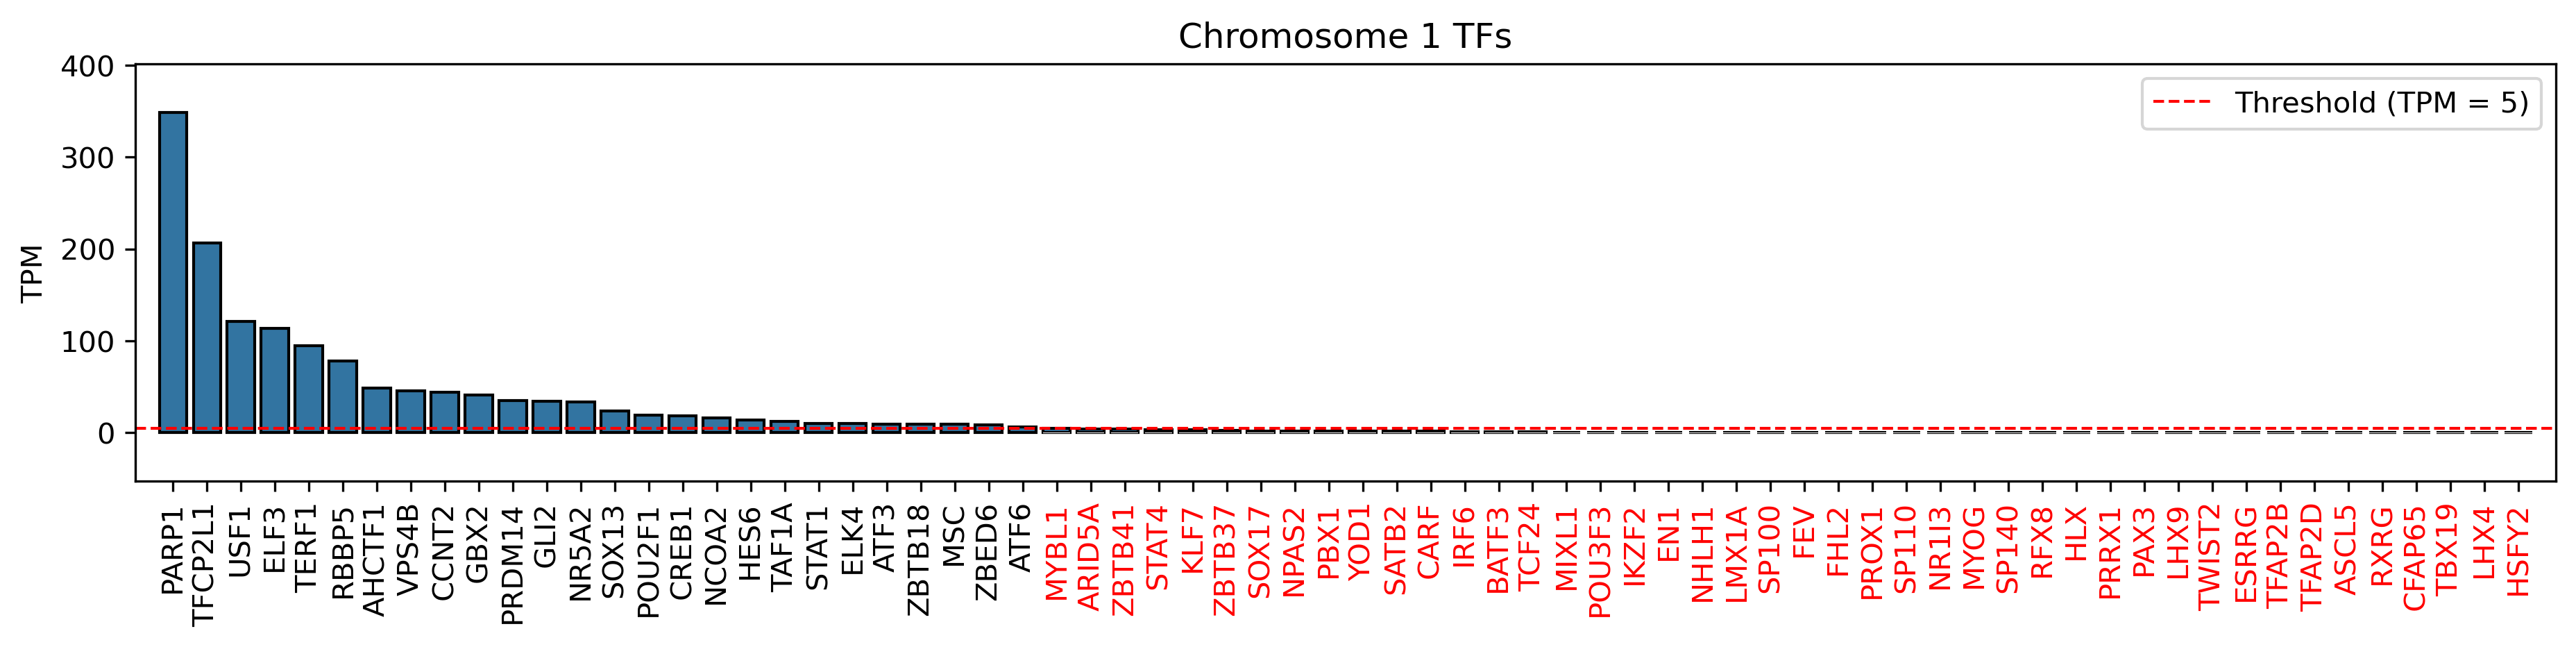

In [17]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 15, 2.6

k = 5 
tpm_values = pdf['TPM']

print(f"n TF with Expression > {k} = {pdf[pdf['TPM'] > k].shape[0]}")

ax = sns.barplot(data=pdf, 
           x='gene_name',
           y='TPM',
           ec='k')

# Add a horizontal line at the threshold
plt.axhline(y=k, 
            color='r', 
            linestyle='dashed',
            linewidth=1,
            label=f'Threshold (TPM = {k})')


# Create a legend for the threshold line
plt.legend()

for item in ax.get_xticklabels():
    gene_name = item.get_text()
    tpm_value = pdf.loc[pdf['gene_name'] == gene_name, 'TPM'].values[0]

    if tpm_value < k:
        item.set_color("red")

# Add white patches behind the gene names for better visibility (optional)
for index, gene_name in enumerate(pdf['gene_name']):
    tpm_value = pdf.loc[pdf['gene_name'] == gene_name, 'TPM'].values[0]
    if tpm_value < k:
        # Calculate the x-coordinate for the patch
        x_coord = index - 0.4  # Adjust width and position as needed
        # Add a white rectangle behind the label
        rect = patches.Rectangle((x_coord, -0.2), 0.8, 0.4, linewidth=0, facecolor='white', transform=ax.transData)
        ax.add_patch(rect)

plt.xlabel("")
plt.ylabel("TPM")

plt.title('Chromosome 1 TFs')
plt.gca().tick_params(axis='x', rotation=90)
plt.margins(y=0.15, x=0.01)

# Plot edges between nodes with highly expressed genes

In [18]:
n_genes = 25
t = 1 # the number of gene-bins that need to be in the concatemer to keep

esc_genes = [
    'PARP1',
    'NCL',
    'MCM3', 
    'HNRNPU',
    'TERF1',
]

pdf = gdf.copy()
pdf = pdf[~pdf['gene_name'].str.startswith("RP")]
pdf['ESC_marker'] = pdf['gene_name'].isin(esc_genes)
pdf = pdf.head(n_genes)

"""Get the unique bins """
gene_bins = pdf['bin'].unique()


gene_hyperedges = df.loc[gene_bins]
print(f"{gene_hyperedges.shape=}")

gene_orders = gene_hyperedges.sum(axis=0)
hyperedge_index = gene_orders[gene_orders >= t].index

Ig = df[hyperedge_index]
print(f"{Ig.shape=}")

gene_hyperedges.shape=(21, 122676)
Ig.shape=(193, 31838)


In [19]:
31838 / 122676

0.259529166259089

In [20]:
pdf[pdf['ESC_marker']]

,gene_name,gene_id,Chromosome,Start,End,midpoint,is_tf,bin,TPM,log_TPM,ESC_marker
743,NCL,ENSMUSG00000026234,1,86272440,86287122,86279781.0,False,87.0,1440.18,7.273218,True
636,HNRNPU,ENSMUSG00000039630,1,178148672,178165362,178157017.0,False,179.0,663.34,6.498794,True
77,PARP1,ENSMUSG00000026496,1,180396488,180428819,180412653.5,True,181.0,348.79,5.857333,True
747,MCM3,ENSMUSG00000041859,1,20873191,20890536,20881863.5,False,21.0,345.23,5.847103,True


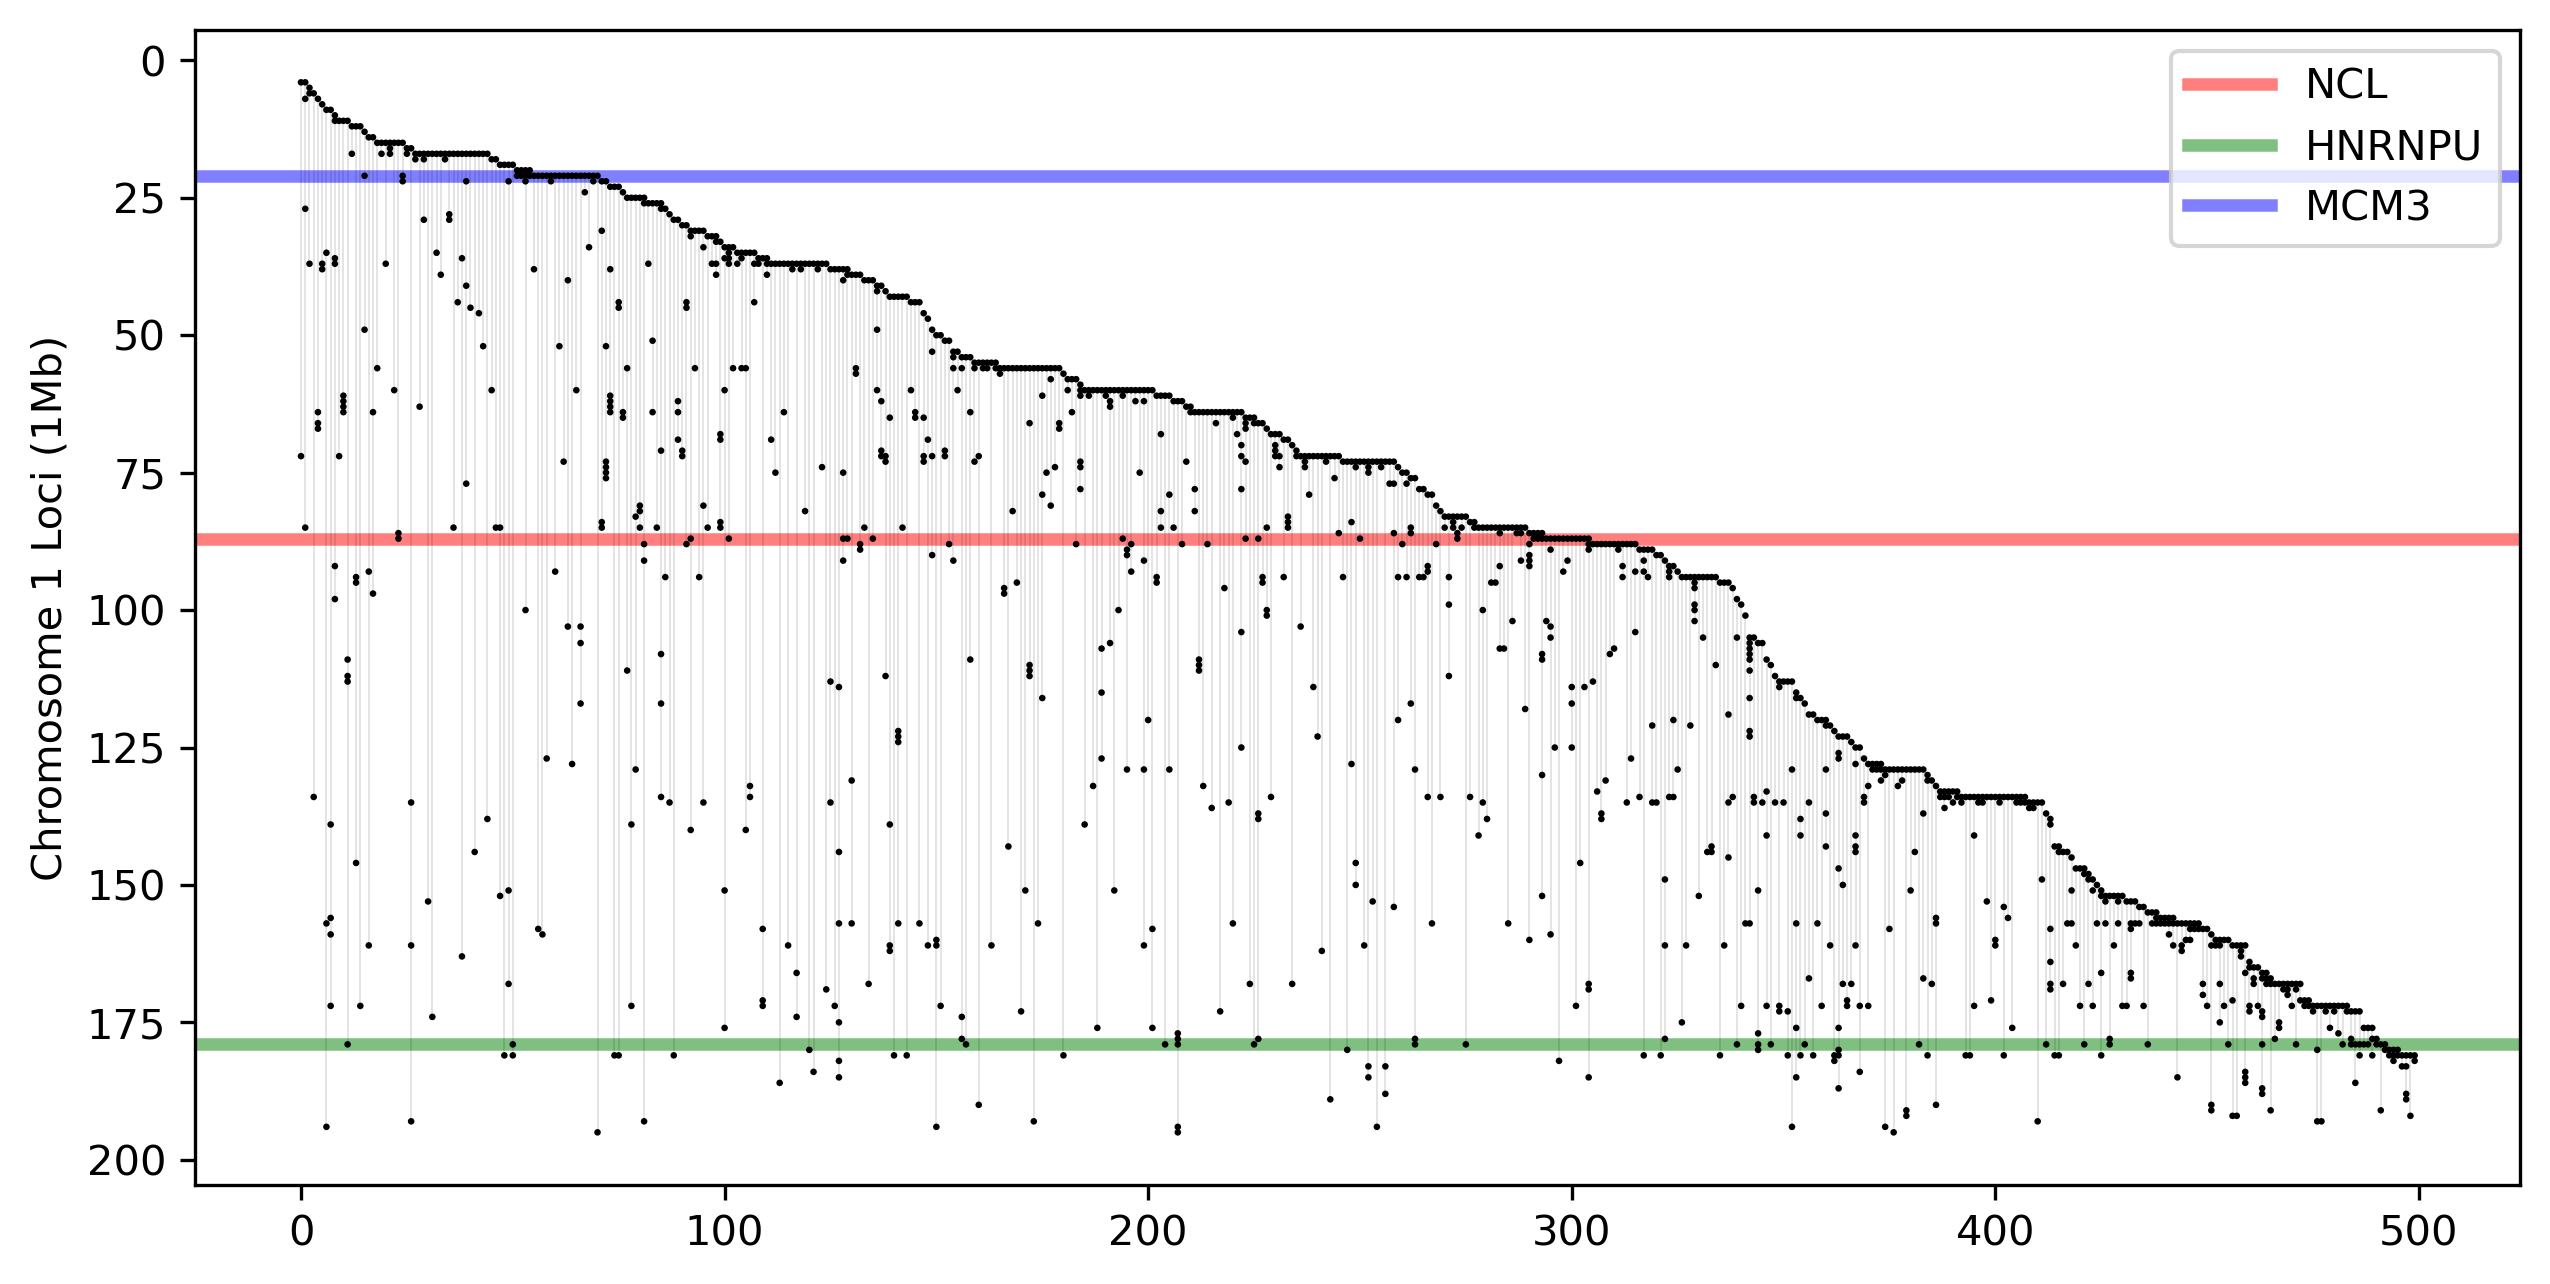

In [21]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 5

node_params = {
    's' : 10,
    'ec' : 'none',
    'lw' : 1,
    'marker' : ".",
    'zorder' : 2,
}

line_params = {
    'lw' : 0.1,
    'alpha' : 0.5,
    'zorder' : 1,
}

sample_size = 500
plt2.plot_incidence(ut.sort_by_lowest_index(Ig.T.sample(sample_size).T), 
               node_color='k',
               node_params=node_params,
               line_params=line_params)

plt.xlabel("")
plt.ylabel("Chromosome 1 Loci (1Mb)")
ax = plt.gca()

# Annotations for the right y-axis
annotate = {
    'NCL' : 'r',
    'HNRNPU' : 'g',
    'MCM3' : 'b',
}

tick_data = pdf[pdf['gene_name'].isin(list(annotate.keys()))]

for _, row in tick_data.iterrows():
    y = row['bin']
    gene = row['gene_name']
    color = annotate[gene]
    ax.axhline(y=y, 
               alpha=0.5,
               lw=3,
               zorder=0, 
               color=color,
               label=gene)
    
plt.legend()

Text(0.5, 191.66666666666657, '')

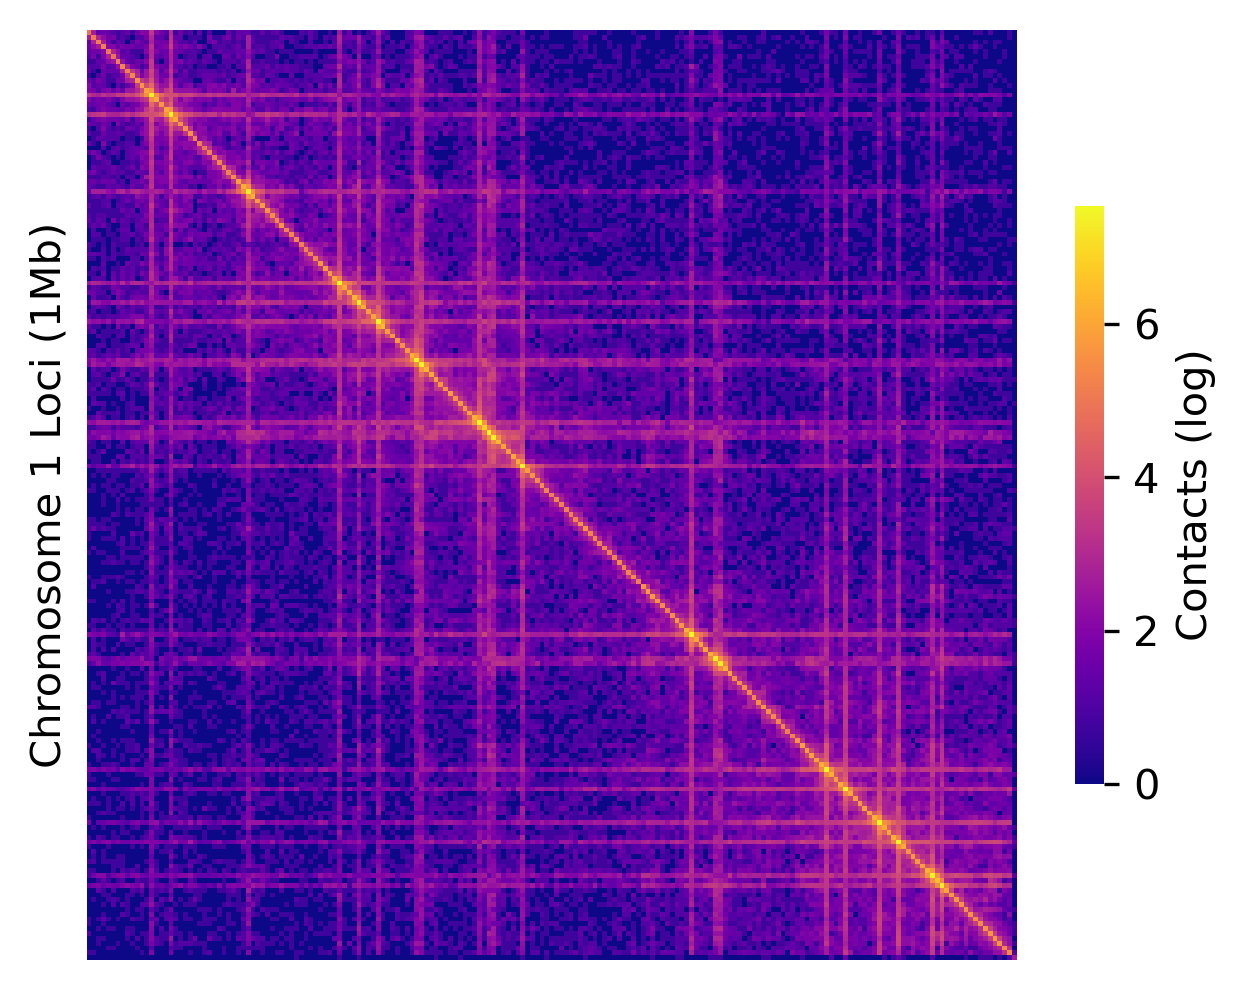

In [22]:
A = matrix.clique_expand_incidence(Ig, zero_diag=False) 
A = A.sort_index(axis=1)
A = A.sort_index(axis=0)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

sns.heatmap(np.log1p(A), 
            cmap='plasma',
            square=True, 
            cbar_kws={'shrink' : 0.5, 'label' : 'Contacts (log)'},
           )

plt.yticks([])
plt.xticks([])

plt.ylabel("Chromosome 1 Loci (1Mb)")
plt.xlabel("")

Text(0.5, 191.66666666666657, '')

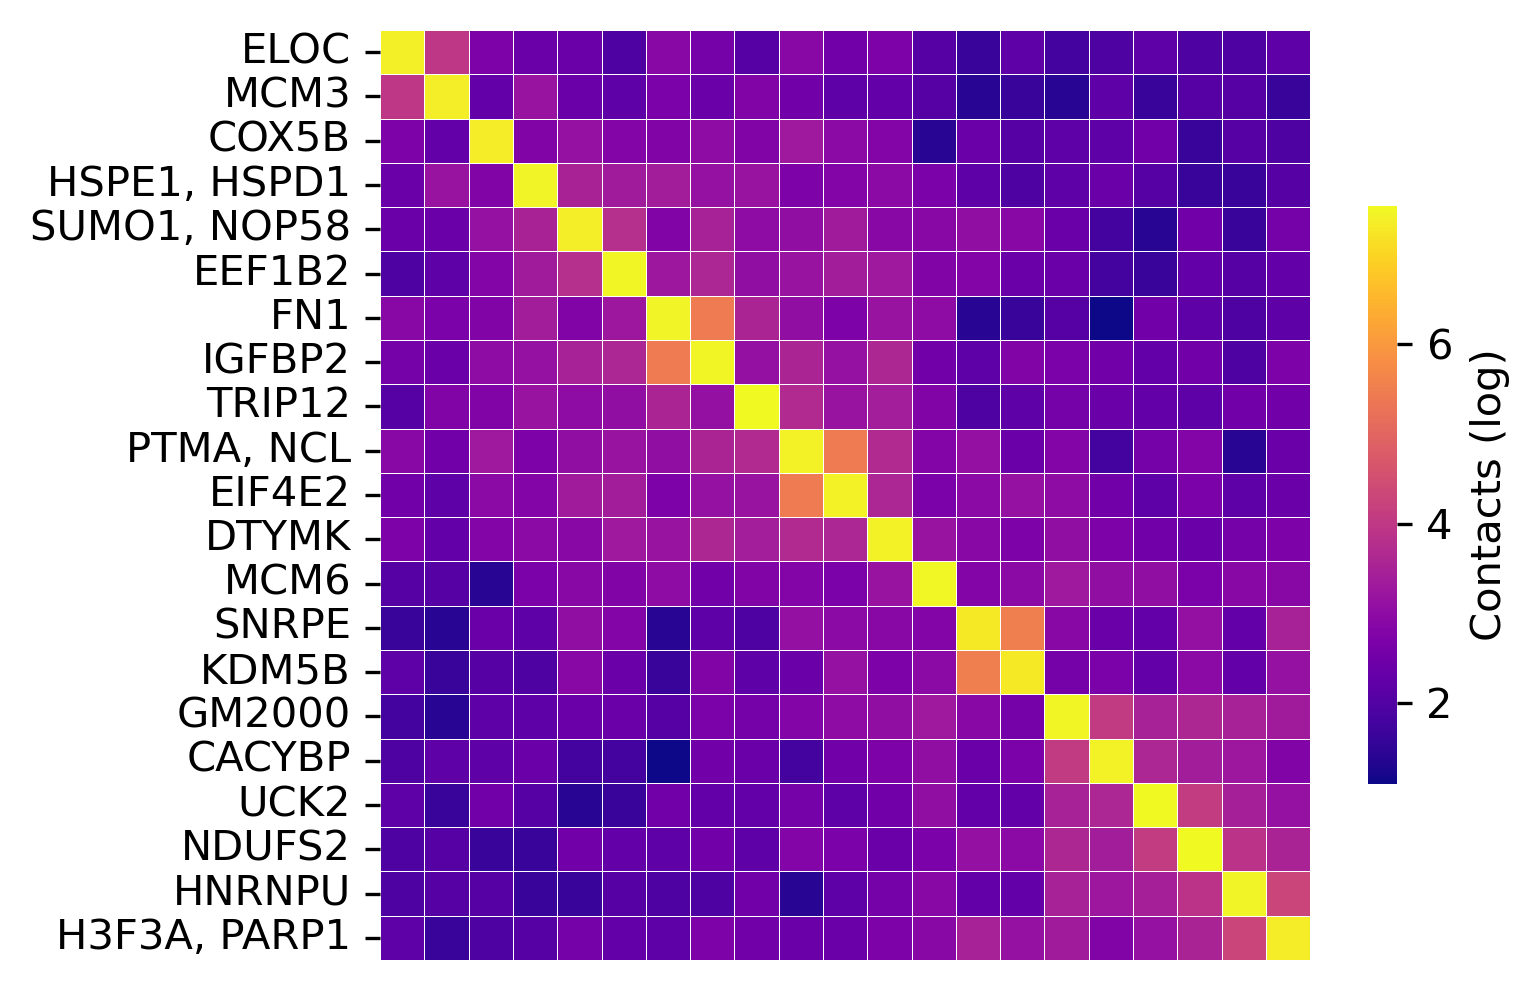

In [23]:
A = matrix.clique_expand_incidence(gene_hyperedges, zero_diag=False) 
A = A.sort_index(axis=1)
A = A.sort_index(axis=0)

index_map = {bin_val: ', '.join(group['gene_name'].unique()) for bin_val, group in pdf.groupby('bin')}

A = A.rename(index=index_map)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

sns.heatmap(np.log1p(A), 
            cmap='plasma',
            lw=0.2,
            square=True, 
            cbar_kws={'shrink' : 0.5, 'label' : 'Contacts (log)'},
           )

# # plt.yticks([])
plt.xticks([])

plt.ylabel("")
plt.xlabel("")

# Hypergraph Centrality

In [24]:
reload(central)

nodes = []

measures = [
    'linear',
    'log-exp', 
    'max',
]

for func in measures:
    
    ncentrality, _ = central.nonlinear_eigenvector_centrality(df.to_numpy(), 
                                                        function=func, 
                                                        maxiter=1000)
    
    nodes.append(pd.DataFrame({func : ncentrality,}, index=df.index))
    
    
nodes = pd.concat(nodes, axis=1).reset_index()
nodes = pd.merge(nodes, gx)

nodes.head()

,bin,linear,log-exp,max,mean_tpm,n_genes,n_tfs,log_TPM
0,4.0,0.002388,0.005107,0.004851,0.020000,1,0,0.019803
1,5.0,0.002916,0.005151,0.005006,53.246667,6,1,3.993542
2,6.0,0.002874,0.005187,0.005009,8.250000,4,0,2.224624
3,7.0,0.003518,0.005222,0.005138,3.813333,3,0,1.571390
4,8.0,0.003023,0.005185,0.005039,18.450000,1,0,2.967847


In [25]:
table = nodes.set_index('bin').corr()
table = table.loc[measures]
table = table.drop(columns=measures + ['mean_tpm']).reset_index()
table = table[['index','log_TPM', 'n_genes', 'n_tfs']]

print(table.round(3).astype(str).to_latex(index=False))

\begin{tabular}{llll}
\toprule
index & log_TPM & n_genes & n_tfs \\
\midrule
linear & 0.21 & 0.261 & 0.236 \\
log-exp & 0.528 & 0.429 & 0.355 \\
max & 0.389 & 0.321 & 0.268 \\
\bottomrule
\end{tabular}



In [26]:
reload(central)
nodes, hyperedges = central.nonlinear_eigenvector_centrality(df.to_numpy(), function='log-exp', maxiter=1000)

nodes = pd.DataFrame({
    'bin' : df.index,
    'centrality' : nodes,
})

nodes['standardized_centrality'] = (nodes['centrality'] - nodes['centrality'].mean()) / nodes['centrality'].std()

nodes = pd.merge(nodes, gx)

cent2tpm = scipy.stats.pearsonr(nodes['centrality'], 
                                nodes['log_TPM'],
                               )

cent2genes = scipy.stats.pearsonr(nodes['centrality'], 
                                nodes['n_genes'],
                               )

cent2tfs = scipy.stats.pearsonr(nodes['centrality'], 
                                nodes['n_tfs'],
                               )

print(f"Centrality vs. Expression: r={cent2tpm[0]:.3f} (p={cent2tpm[1]:.3f})")
print(f"Centrality vs. n Genes: r={cent2genes[0]:.3f} (p={cent2genes[1]:.3f})")
print(f"Centrality vs. n TFs: r={cent2tfs[0]:.3f} (p={cent2tfs[1]:.3f})")

Centrality vs. Expression: r=0.528 (p=0.000)
Centrality vs. n Genes: r=0.429 (p=0.000)
Centrality vs. n TFs: r=0.355 (p=0.000)


Fri Jun  7 09:14:04 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Fri Jun  7 09:14:04 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Fri Jun  7 09:14:04 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Fri Jun  7 09:14:04 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Fri Jun  7 09:14:05 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates

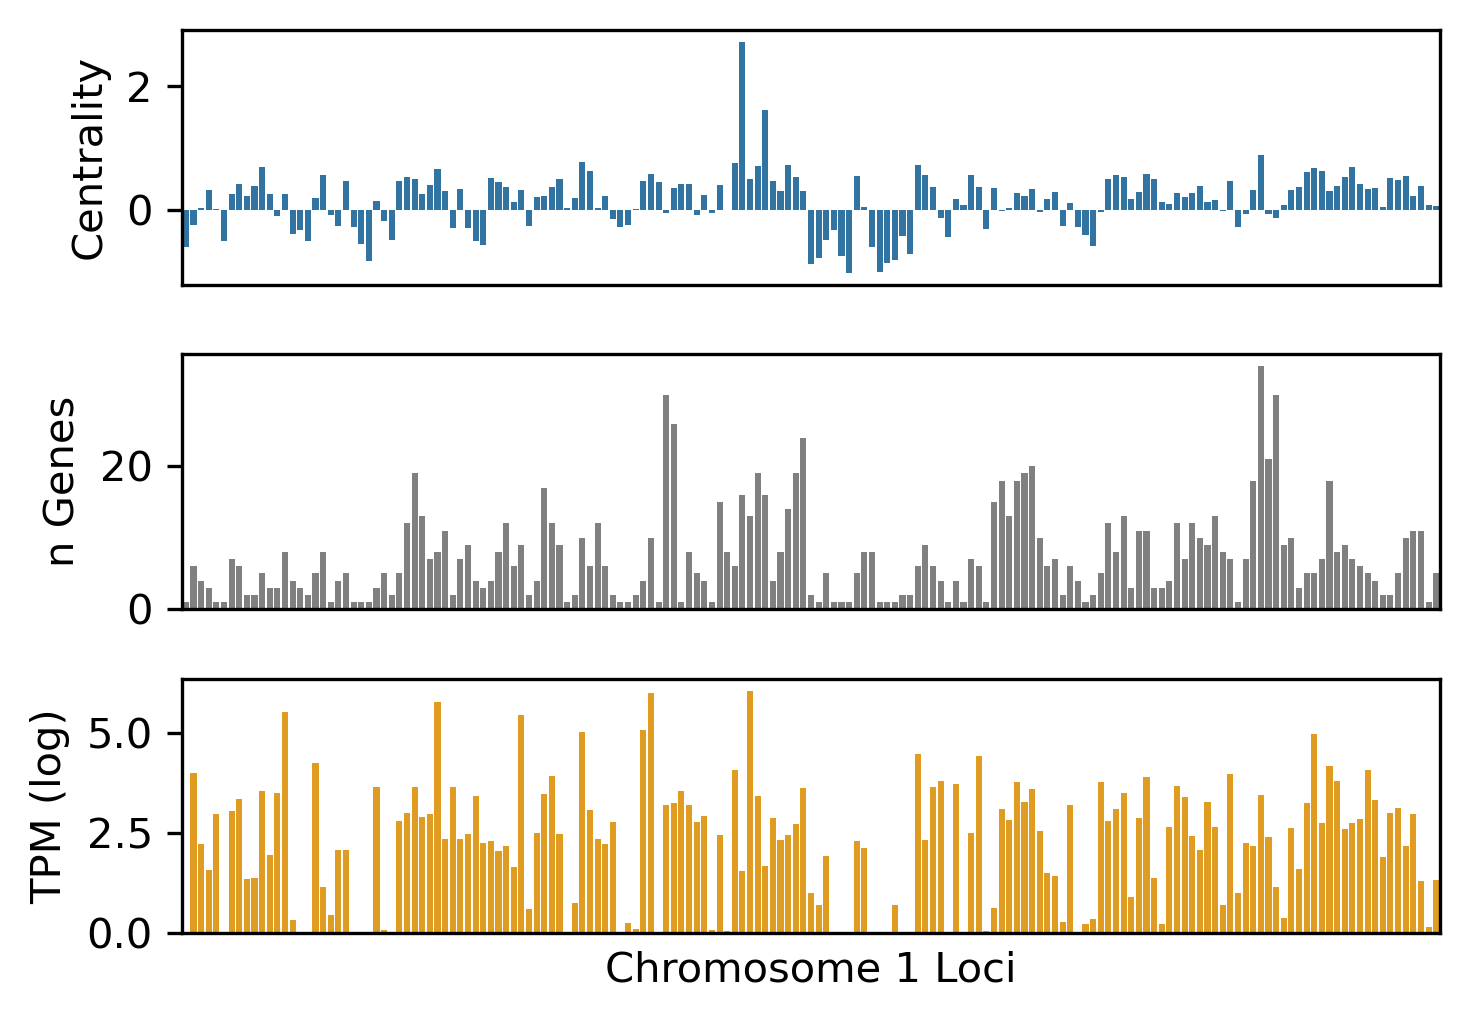

In [27]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 3.5

fig, axs = plt.subplots(3, 1, sharex=True)

sns.barplot(data=nodes, 
            x='bin',
            y='standardized_centrality',
            ax=axs[0])

sns.barplot(data=nodes, 
            x='bin', 
            y='n_genes',
            color='grey',
            ax=axs[1])


sns.barplot(data=nodes, 
            x='bin', 
            y='log_TPM',
            color='orange',
            ax=axs[2])

axs[0].set_ylabel('Centrality')
axs[1].set_ylabel('n Genes')
axs[2].set_ylabel('TPM (log)')
plt.xticks([])
plt.xlabel("Chromosome 1 Loci")

plt.tight_layout()


In [28]:
# break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [70]:
# compare against population Hi-C

reload(matrix)
fpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/population_hic/chr1_1000000.parquet"

hic = pd.read_parquet(fpath)
A = hic.to_numpy()
print(f"{A.shape=}")

# drop the telomere
A = A[3:, :][:, 3:]
print(f"{A.shape=}")

Anorm = matrix.normalize_oe(matrix.normalize_kr(A).todense())

# correct outliers
top = 500
row_idx, col_idx = matrix.get_sorted_upper_triangle_indices(Anorm)

# update the matrix 
for i in range(top):
    Anorm[row_idx[i], col_idx[i]] = Anorm.mean()

print(f"{A.shape=}")

A.shape=(196, 196)
A.shape=(193, 193)
A.shape=(193, 193)


/tmp/ipykernel_729712/196106280.py:5: RuntimeWarning: invalid value encountered in log1p
  plt.plot(np.log1p(eigenvalues))


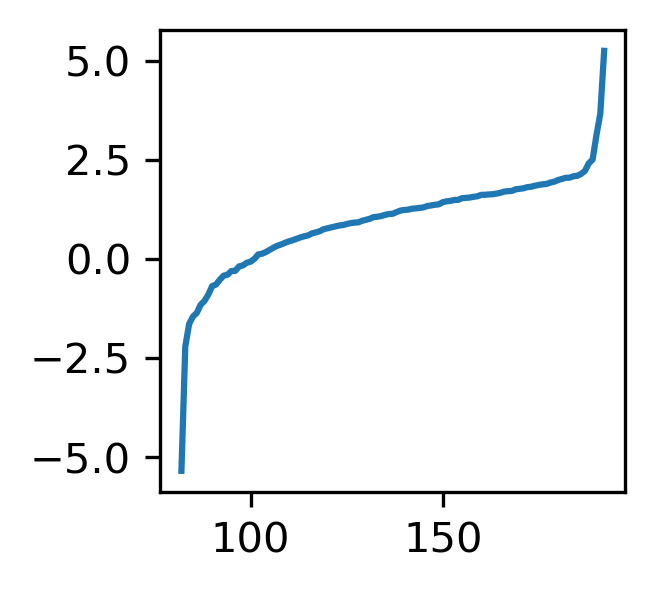

In [44]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 2, 2

eigenvalues, eigenvectors = np.linalg.eigh(Anorm)
plt.plot(np.log1p(eigenvalues))

In [91]:
reload(central)
nodes, hyperedges = central.nonlinear_eigenvector_centrality(df.to_numpy(), function='log-exp', maxiter=1000)

nodes = pd.DataFrame({
    'bin' : df.index,
    'centrality' : nodes,
    'eigenvector' :  np.ravel(eigenvectors[:, -1]),
})

nodes['pore_c'] = (nodes['centrality'] - nodes['centrality'].mean()) / nodes['centrality'].std()
nodes['hi_c'] = (nodes['eigenvector'] - nodes['eigenvector'].mean()) / nodes['eigenvector'].std()

nodes[['pore_c', 'hi_c']].head(192).corr()

,pore_c,hi_c
pore_c,1.000000,0.343756
hi_c,0.343756,1.000000


Fri Jun  7 09:44:58 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Fri Jun  7 09:44:58 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Fri Jun  7 09:44:58 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Fri Jun  7 09:44:58 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 0, 'Chromosome 1 Loci')

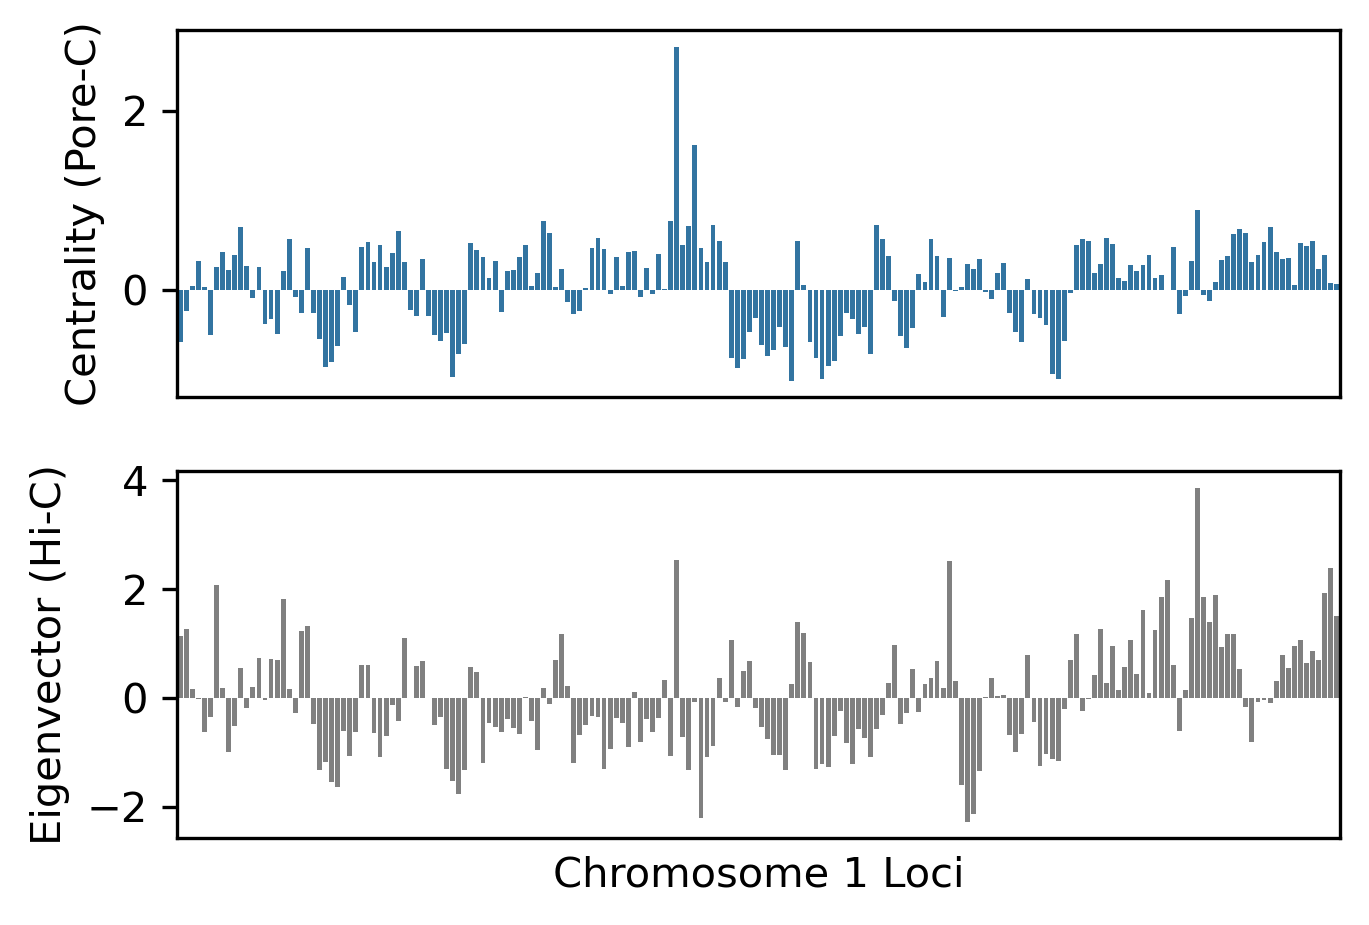

In [92]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 3.5

fig, axs = plt.subplots(2, 1, sharex=True)

sns.barplot(data=nodes.head(192), 
            x='bin',
            y='pore_c',
            ax=axs[0])

sns.barplot(data=nodes.head(192), 
            x='bin', 
            y='hi_c',
            color='grey',
            ax=axs[1])

axs[0].set_ylabel('Centrality (Pore-C)')
axs[1].set_ylabel('Eigenvector (Hi-C)')
plt.xticks([])
plt.xlabel("Chromosome 1 Loci")

In [98]:
# who is the max bin?
nodes[nodes['pore_c'] == nodes['pore_c'].max()]

,bin,centrality,eigenvector,pore_c,hi_c
82,86.0,0.005527,0.091563,2.716826,2.537984


In [109]:
gdf[gdf['bin'].isin([86.0, 87.0])]

,gene_name,gene_id,Chromosome,Start,End,midpoint,is_tf,bin,TPM,log_TPM
116,PTMA,ENSMUSG00000026238,1,86454447,86458434,86456440.5,False,87.0,3779.20,8.237532
743,NCL,ENSMUSG00000026234,1,86272440,86287122,86279781.0,False,87.0,1440.18,7.273218
462,PSMD1,ENSMUSG00000026229,1,85992108,86066873,86029490.5,False,87.0,139.89,4.947979
97,CAB39,ENSMUSG00000036707,1,85721161,85779297,85750229.0,False,86.0,31.70,3.487375
122,COPS7B,ENSMUSG00000026240,1,86510625,86537097,86523861.0,False,87.0,30.31,3.443938
750,PDE6D,ENSMUSG00000026239,1,86470715,86510351,86490533.0,False,87.0,29.81,3.427839
98,ITM2C,ENSMUSG00000026223,1,85822001,85836396,85829198.5,False,86.0,27.93,3.364879
465,B3GNT7,ENSMUSG00000079445,1,86230553,86235027,86232790.0,False,87.0,17.19,2.900872
130,DIS3L2,ENSMUSG00000053333,1,86631529,86977817,86804673.0,False,87.0,11.09,2.492379
464,ARMC9,ENSMUSG00000062590,1,86082501,86206006,86144253.5,False,87.0,7.16,2.099244


# Weighted Centrality

In [101]:
node_weights = pd.DataFrame(df.index)

node_weights = pd.merge(node_weights, gx, 
                        how='left',
                        left_on='bin',
                        right_on='bin')

node_weights = node_weights.fillna(0)

print(f"{node_weights.shape=}")

weight_vector = node_weights['log_TPM'].values.reshape(-1, 1)
print(f"{weight_vector.shape=}")

# print(node_weights.shape)
nodes, _ = central.nonlinear_eigenvector_centrality(df.to_numpy(), 
                                                    function='linear',
                                                    maxiter=1000,
                                                    node_weights=weight_vector)
node_weights['w_centrality'] = nodes.ravel()
node_weights.head()       

node_weights.shape=(193, 5)
weight_vector.shape=(193, 1)


,bin,mean_tpm,n_genes,n_tfs,log_TPM,w_centrality
0,4.0,0.020000,1.0,0.0,0.019803,0.001862
1,5.0,53.246667,6.0,1.0,3.993542,0.003380
2,6.0,8.250000,4.0,0.0,2.224624,0.002739
3,7.0,3.813333,3.0,0.0,1.571390,0.002829
4,8.0,18.450000,1.0,0.0,2.967847,0.002811


# Node Clustering

Text(1110.0833333333337, 0.5, '')

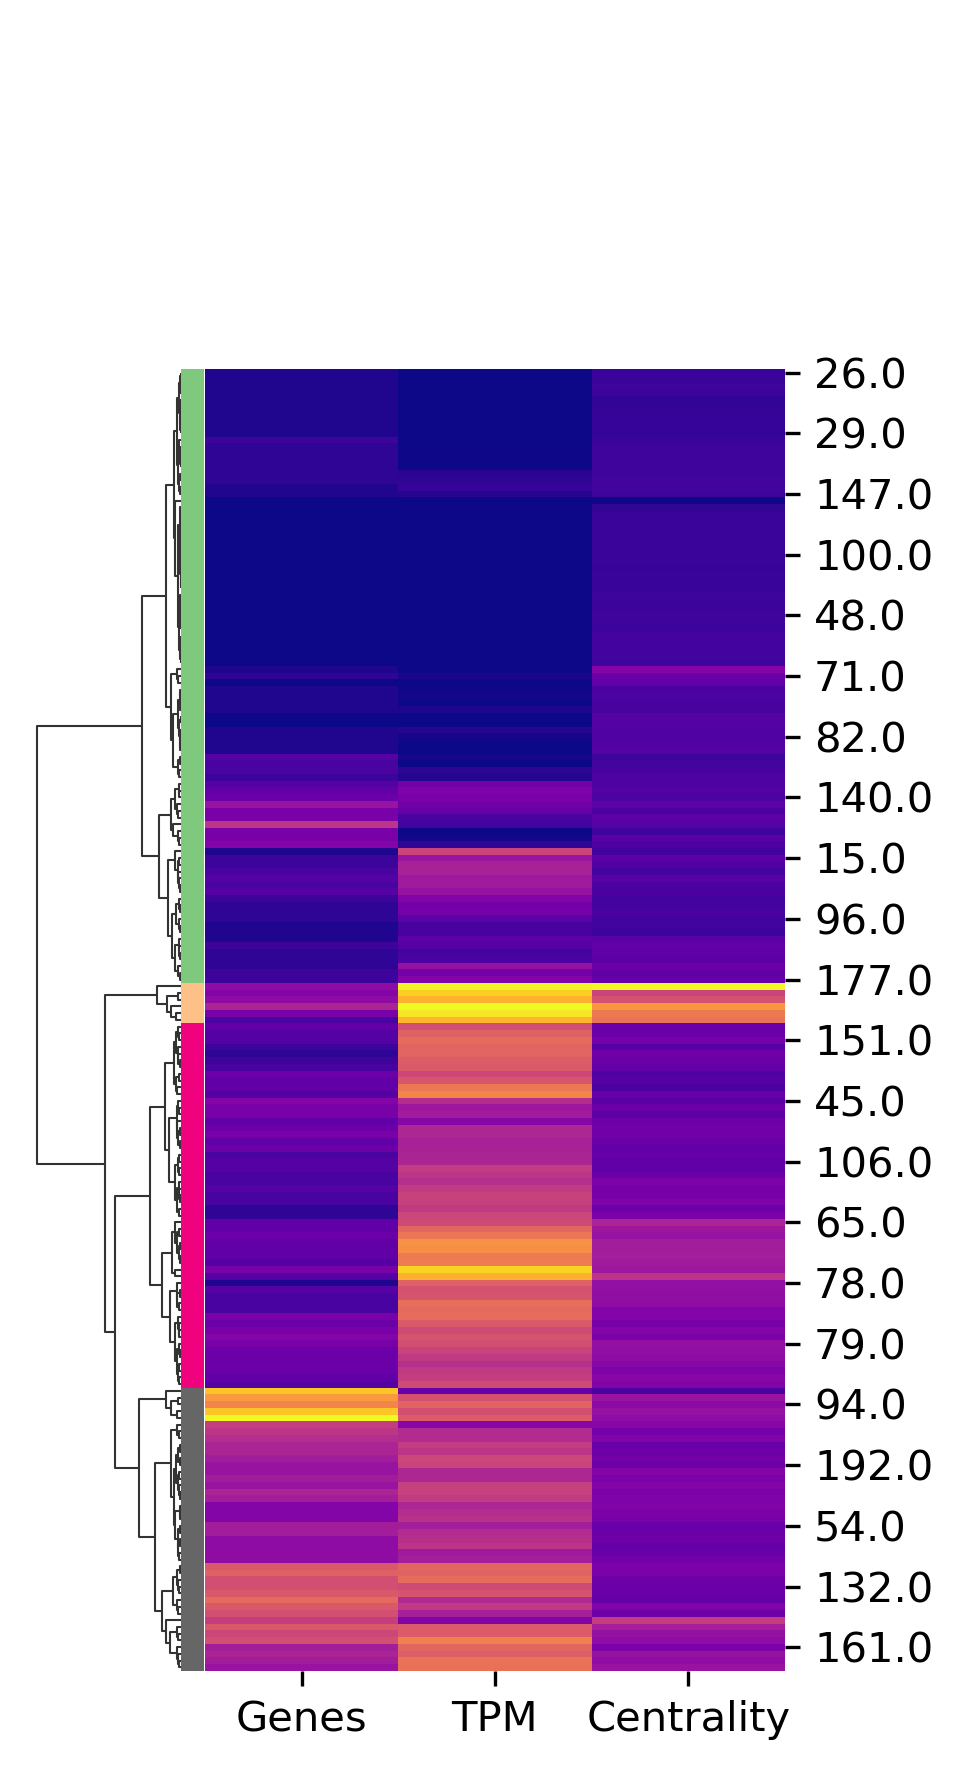

In [103]:
pdf = node_weights.set_index('bin').copy()

pdf.columns = ['mean_tpm', 'Genes', 'TFs', 'TPM', 'Centrality']
pdf = pdf.drop(columns=['mean_tpm', 'TFs'])

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pdf)
Z = linkage(X_scaled, method='ward')

max_d = 7
clusters = fcluster(Z, max_d, criterion='distance')
row_colors = clusters
row_colors = plt2.floats_to_colors(row_colors, colormap='Accent')

sns.clustermap(data=pdf,
               standard_scale=1,
               row_colors=row_colors,
               row_linkage=Z,
               figsize=(3.5, 6),
               # cbar=False,
               cbar_pos=None,
               cmap='plasma',
               col_cluster=False)

plt.ylabel("")

In [104]:
pdf.iloc[np.argwhere(clusters == 2).ravel()]

,Genes,TPM,Centrality
bin,,,
40.0,8.0,5.762649,0.016969
56.0,9.0,5.445218,0.012542
64.0,10.0,5.015344,0.013761
72.0,4.0,5.070444,0.016664
73.0,10.0,5.993667,0.025470
87.0,13.0,6.041768,0.019149


In [105]:
genes = gdf[gdf['bin'].isin(pdf[pdf['Centrality'] == pdf['Centrality'].max()].index)]

print(genes[['gene_name', 'midpoint', 'log_TPM']])

database = 'ontology'
result = gget.enrichr(genes['gene_name'].to_list(), database=database)

result.head(5)


Fri Jun  7 09:47:06 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


     gene_name    midpoint   log_TPM
381     RPL37A  72751710.0  8.071212
382     IGFBP2  72877647.0  6.305253
993       MREG  72225033.0  4.854293
368      XRCC5  72390348.0  4.494462
377   SMARCAL1  72647351.0  3.123686
995       PECR  72310899.0  2.747912
1003    IGFBP5  72905566.5  0.207014
996    MARCHF4  72521179.5  0.019803
1002     ANKAR  72710938.0  0.000000
367    TMEM169  72332895.0  0.000000


,rank,path_name,p_val,z_score,combined_score,overlapping_genes,adj_p_val,database
0,1,regulation of insulin-like growth factor recep...,0.000038,293.720588,2987.148937,"[IGFBP5, IGFBP2]",0.004558,GO_Biological_Process_2021
1,2,regulation of smooth muscle cell proliferation...,0.000261,106.079787,875.138256,"[IGFBP5, XRCC5]",0.015548,GO_Biological_Process_2021
2,3,double-strand break repair via nonhomologous e...,0.000419,83.041667,645.922108,"[SMARCAL1, XRCC5]",0.016610,GO_Biological_Process_2021
3,4,cellular protein metabolic process (GO:0044267),0.000968,20.265010,140.639211,"[IGFBP5, IGFBP2, RPL37A]",0.028806,GO_Biological_Process_2021
4,5,negative regulation of insulin-like growth fac...,0.002498,555.166667,3326.770642,[IGFBP5],0.037693,GO_Biological_Process_2021


In [106]:
genes = gdf[gdf['bin'].isin(pdf.iloc[np.argwhere(clusters == 2).ravel()].index)]

print(genes[['gene_name', 'midpoint', 'log_TPM']])

database = 'ontology'
result = gget.enrichr(genes['gene_name'].head(10).to_list(), database=database)

result.head(5)

Fri Jun  7 09:47:10 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


     gene_name    midpoint   log_TPM
116       PTMA  86456440.5  8.237532
381     RPL37A  72751710.0  8.071212
333      RPL31  39408957.0  7.779952
743        NCL  86279781.0  7.273218
473     EEF1B2  63217814.0  7.191640
123      HSPE1  55128878.0  7.034414
754      HSPD1  55122197.5  6.676643
382     IGFBP2  72877647.0  6.305253
990        FN1  71658518.5  6.148105
340       ATIC  71607549.0  5.015822
462      PSMD1  86029490.5  4.947979
993       MREG  72225033.0  4.854293
749      SF3B1  55045483.5  4.731450
1087    NDUFS1  63199373.0  4.582209
368      XRCC5  72390348.0  4.494462
330      PDCL3  39030503.5  4.064572
338     CNOT11  39580021.0  4.012592
525    FASTKD2  63781793.0  3.530177
122     COPS7B  86523861.0  3.443938
750      PDE6D  86490533.0  3.427839
1130    RNF149  39603431.0  3.392493
377   SMARCAL1  72647351.0  3.123686
128       MOB4  55182223.5  2.970414
523     ADAM23  63560242.0  2.938103
465     B3GNT7  86232790.0  2.900872
967      BARD1  71104480.5  2.853593
9

,rank,path_name,p_val,z_score,combined_score,overlapping_genes,adj_p_val,database
0,1,cellular macromolecule biosynthetic process (G...,0.000012,42.322581,480.911577,"[EEF1B2, RPL31, RPL37A, PTMA]",0.001390,GO_Biological_Process_2021
1,2,gene expression (GO:0010467),0.000019,37.193182,404.243956,"[RPL31, RPL37A, PTMA, HSPD1]",0.001390,GO_Biological_Process_2021
2,3,cellular protein metabolic process (GO:0044267),0.000035,31.601291,323.865180,"[RPL31, IGFBP2, RPL37A, FN1]",0.001723,GO_Biological_Process_2021
3,4,translation (GO:0006412),0.000137,40.174001,357.329206,"[EEF1B2, RPL31, RPL37A]",0.005005,GO_Biological_Process_2021
4,5,response to unfolded protein (GO:0006986),0.000261,106.079787,875.138256,"[HSPE1, HSPD1]",0.007630,GO_Biological_Process_2021


In [107]:
# extract this "core"
t = 1 # the number of gene-bins that need to be in the concatemer to keep

"""Get the unique bins """
gene_bins = pdf.iloc[np.argwhere(clusters == 2).ravel()].index

gene_hyperedges = df.loc[gene_bins]
print(f"{gene_hyperedges.shape=}")

gene_orders = gene_hyperedges.sum(axis=0)
hyperedge_index = gene_orders[gene_orders >= t].index

Ig = df[hyperedge_index]
print(f"{Ig.shape=}")

gene_hyperedges.shape=(6, 122676)
Ig.shape=(193, 9876)


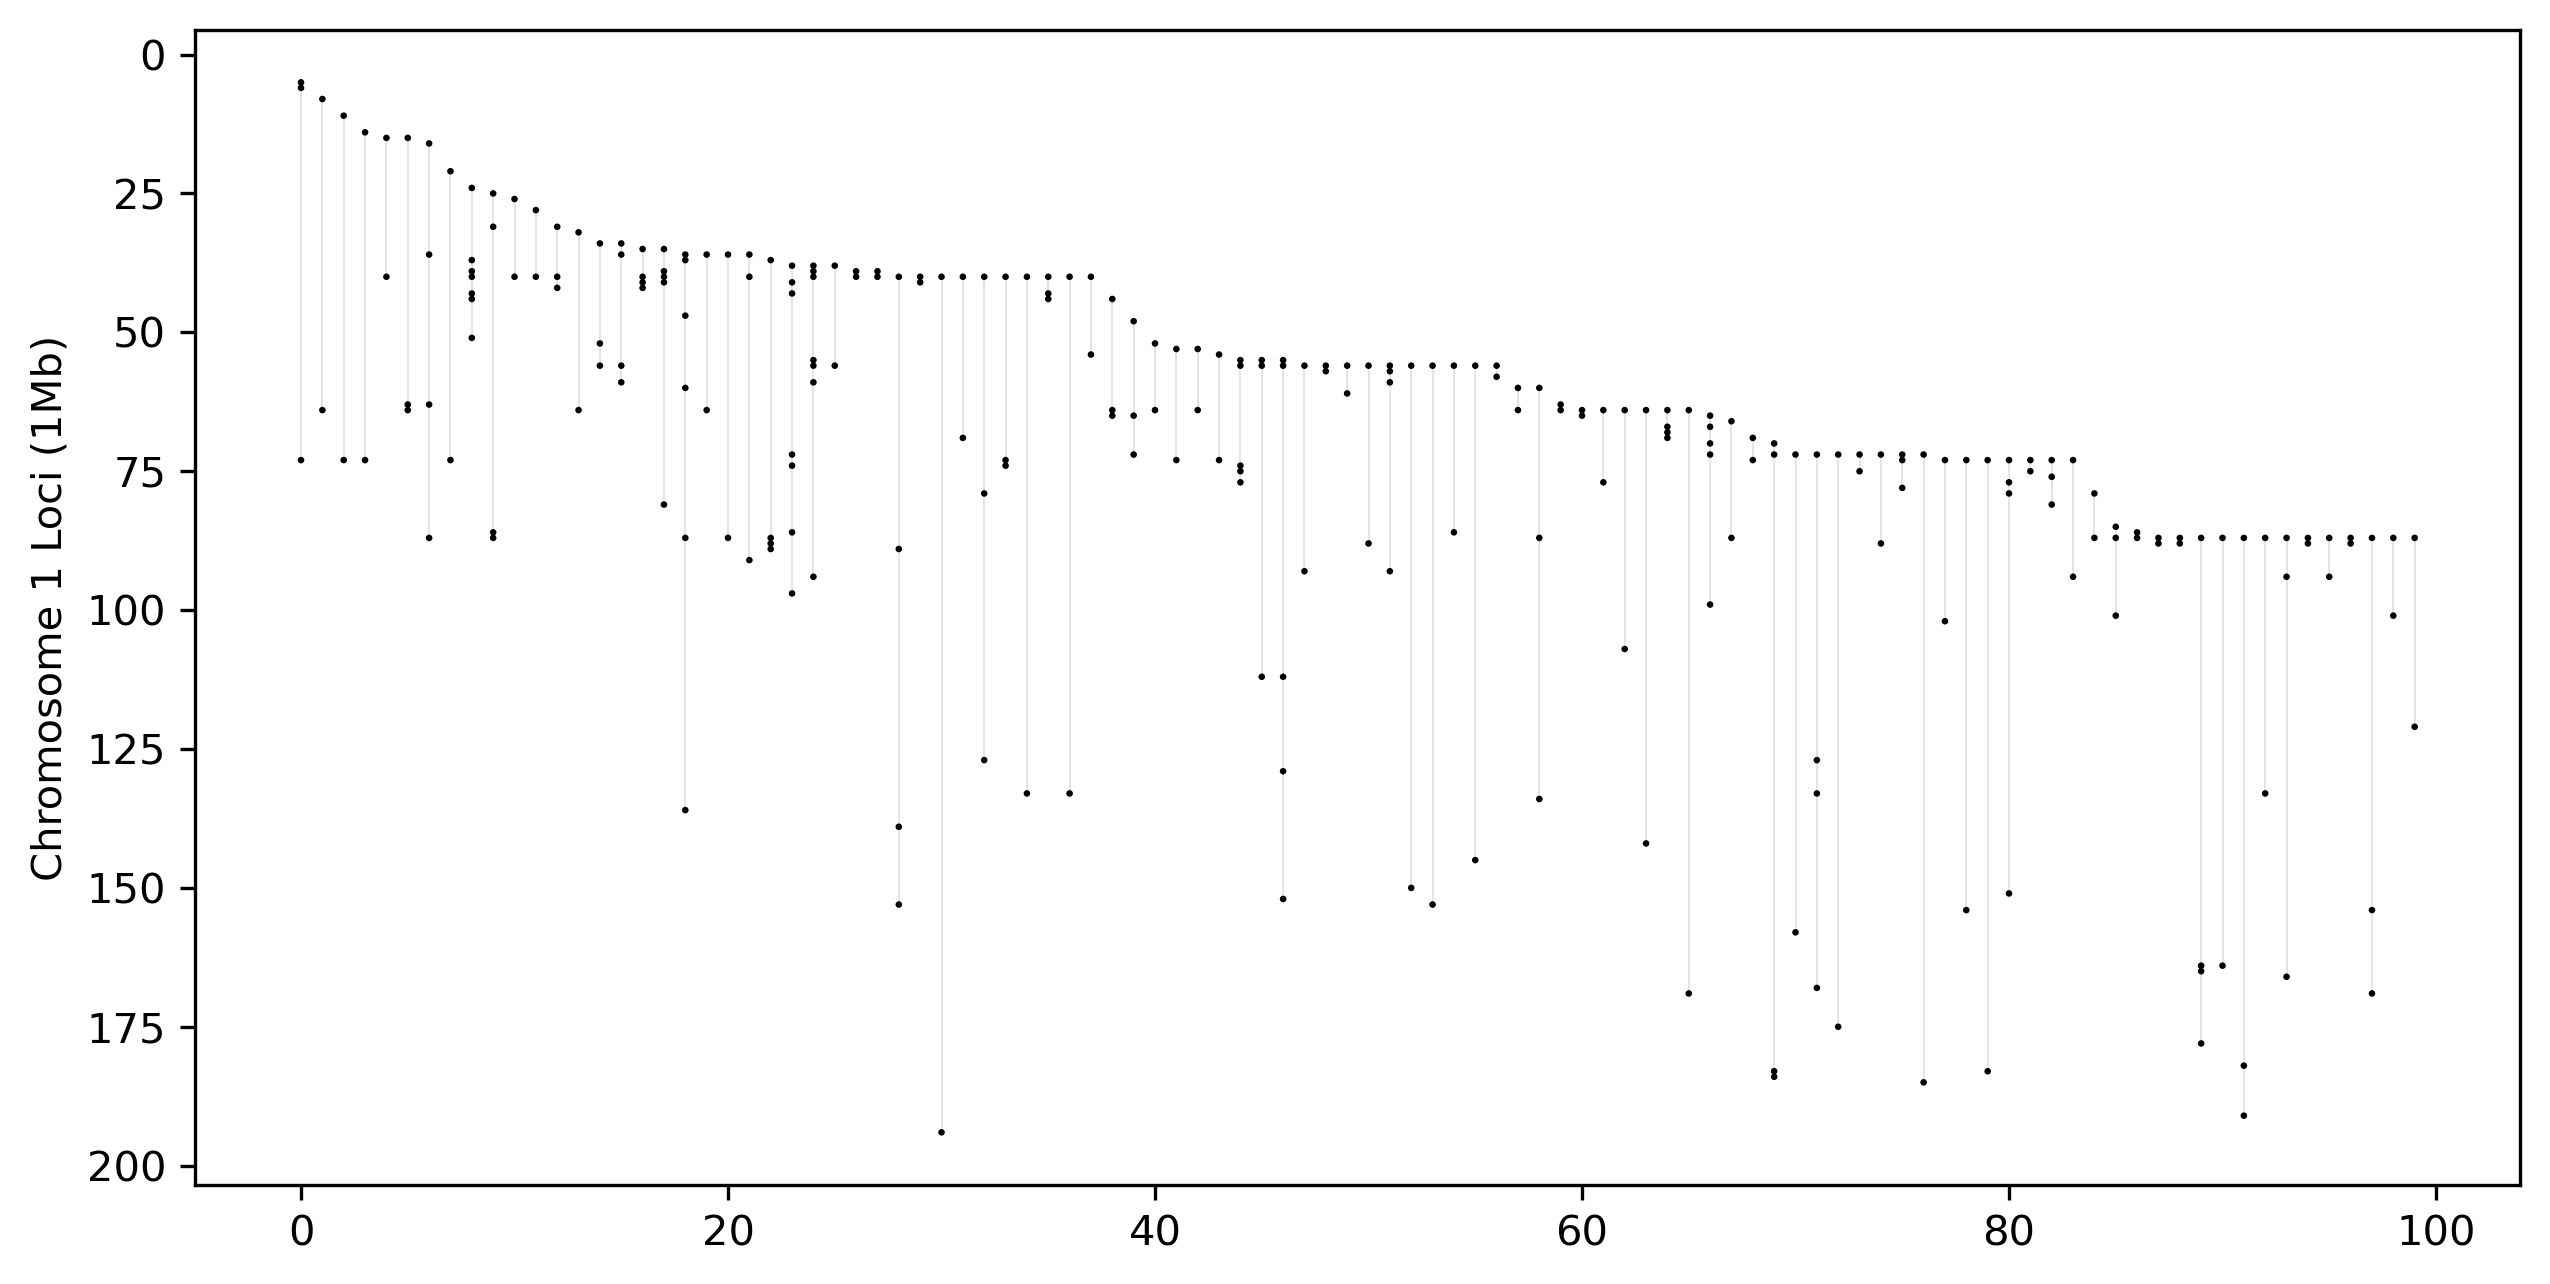

In [110]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 5

node_params = {
    's' : 10,
    'ec' : 'none',
    'lw' : 1,
    'marker' : ".",
    'zorder' : 2,
}

line_params = {
    'lw' : 0.1,
    'alpha' : 0.5,
    'zorder' : 1,
}

sample_size = 100
plt2.plot_incidence(ut.sort_by_lowest_index(Ig.T.sample(sample_size).T), 
               node_color='k',
               node_params=node_params,
               line_params=line_params)

plt.xlabel("")
plt.ylabel("Chromosome 1 Loci (1Mb)")
ax = plt.gca()

In [ ]:
break

# k-m Core decomposition

In [ ]:
m = 3
k = 450

# prepare data
data = ut.incidence_to_list_of_list(df)
data = hc.prepare_for_hypercore_decomp(data, k=2)

# perform decomposition
mk_hyper = hc.m_k_decomposition(data, m, k)
print(mk_hyper)

I = hc.xgi_to_incidence(mk_hyper)
A = matrix.clique_expand_incidence(I, zero_diag=False)  

print(f"{I.shape=} {A.shape=}")

In [ ]:
function = 'log-exp'
maxiter = 1000

full_centrality, _ = central.nonlinear_eigenvector_centrality(df.to_numpy(), 
                                                              function=function, 
                                                              maxiter=maxiter)

core_centrality, _ = central.nonlinear_eigenvector_centrality(ut.fill_missing_bins(I, df.index), 
                                                              function=function, 
                                                              maxiter=maxiter)

nodes = pd.DataFrame({
    'full_centrality' : full_centrality,
    'core_centrality' : core_centrality,
}, index=df.index)

nodes.corr()

In [ ]:
reload(central)

nodes = []

measures = [
    'linear',
    'log-exp', 
    'max',
]

for func in measures:
    
    ncentrality, _ = central.nonlinear_eigenvector_centrality(I.to_numpy(), 
                                                        function=func, 
                                                        maxiter=1000)
    
    nodes.append(pd.DataFrame({func : ncentrality,}, index=df.index))
    
    
nodes = pd.concat(nodes, axis=1).reset_index()
nodes = pd.merge(nodes, gx)

table = nodes.set_index('bin').corr()
table = table.loc[measures]
table = table.drop(columns=measures + ['mean_tpm']).reset_index()
table = table[['index','log_TPM', 'n_genes', 'n_tfs']]

table

In [ ]:
reload(ut)
# plot bin level gene counts

degrees = df.sum(axis=1).reset_index()
degrees.columns = ['bin', 'degree']
degrees['degree'] = ut.min_max(degrees['degree'])

gx = gdf.groupby('bin').agg(
    n_genes = ('gene_name', 'count'),
    n_tfs = ('is_tf', 'sum'),
).reset_index()

gx = pd.merge(gx, degrees)
gx = pd.merge(gx, degrees_core)
gx['bin'] = gx['bin'].astype(int)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 4

fig, axs = plt.subplots(4, 1, sharex=True)

labels = [
    'Degree',
    'Degree (core)',
    'n Genes',
    'n TFs',
]

for i, c in enumerate(['degree', 'degree_core', 'n_genes', 'n_tfs']):
    
    sns.barplot(data=gx, 
                x='bin', 
                y=c,
                ax=axs[i],
               )
    axs[i].set_ylabel(labels[i])

plt.xticks(np.linspace(0, 193, 5).astype(int))
plt.xlim([-1, 170])
plt.xlabel("Chromosome 1 Loci (1Mb)")

In [ ]:
# plot bin level gene counts

gx = gdf.groupby('bin').agg(
    n_genes = ('gene_name', 'count'),
    n_tfs = ('is_tf', 'sum'),
).reset_index()


gx['bin'] = gx['bin'].astype(int)

print(gx['bin'].max())

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 2

sns.barplot(data=gx, 
            x='bin', 
            y='n_genes')

sns.barplot(data=gx, 
            x='bin', 
            y='n_tfs',
            color='r'
           )

plt.xticks(np.linspace(0, 193, 5))
plt.xlim([-1, 170])
plt.xlabel("Chromosome 1 Loci")
plt.ylabel("n Genes")

gx.head()

# MK Core decomposition

In [ ]:
m = 3
k = 40

# prepare data
data = ut.incidence_to_list_of_list(df)
data = hc.prepare_for_hypercore_decomp(data, k=2)

# perform decomposition
mk_hyper = hc.m_k_decomposition(data, m, k)
print(mk_hyper)

I = hc.xgi_to_incidence(mk_hyper)
A = matrix.clique_expand_incidence(I, zero_diag=False)  

print(f"{I.shape=} {A.shape=}")

In [ ]:
plt.imshow(np.log1p(A))

In [ ]:
break

In [ ]:
res = []

n_nodes, n_edges = df.shape
orders = df.sum(axis=0)
high_order_idx = np.argwhere(orders.values > 3).ravel()
ho_degrees = df[df.columns[high_order_idx]].sum(axis=1)

data = ut.incidence_to_list_of_list(df)
data = hc.prepare_for_hypercore_decomp(data, k=2)

M = list(range(3, 8))
K = list(range(10, 100, 2))

for k in K:
    for m in M:
        mk_hyper = hc.m_k_decomposition(data, m, k)
        
        row = {
            'm' : m,
            'k' : k,
            'nodes' : len(mk_hyper.nodes) / n_nodes ,
            'edges' : len(mk_hyper.edges) / n_edges,
        }
        res.append(row)
        
res = pd.DataFrame(res)
res.head()